# Movie Recommendation

## Project 2, Team 2

**Import libraries and load the dataset**

In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Load the dataset
data = pd.read_csv('resources/movies_metadata.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tarunmidha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Pre-process and clean the data**

In [2]:
# Drop unnecessary columns
data = data.drop(columns=['id', 'original_title', 'production_companies', 'production_countries', 'status', 'tagline'])

# Remove rows with missing data
data = data.dropna()

# Convert release_date to datetime
data['release_date'] = pd.to_datetime(data['release_date'])

**Create a function to extract keywords from the overview**

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_keywords(text):
    # Remove punctuation
    text = ''.join([c for c in text if c not in punctuation])

    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    # Return a list of keywords
    return tokens


**Create a TF-IDF matrix for the overview text**

In [4]:
tfidf = TfidfVectorizer(tokenizer=get_keywords)
tfidf_matrix = tfidf.fit_transform(data['overview'])

**Calculate cosine similarity between movies**

In [5]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

**Create a function to get movie recommendations based on keywords**

In [6]:
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return data['title'].iloc[movie_indices]


In [7]:
# Reset the index of the 'data' DataFrame
data.reset_index(drop=True, inplace=True)

# Update the 'indices' Series
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

# Test the get_recommendations function
# Ask the user to input a movie title
user_movie_title = input("Enter a movie title: ")

try:
    # Test the get_recommendations function
    recommended_movies = get_recommendations(user_movie_title)
    print(f"Recommended movies for '{user_movie_title}':")
    print(recommended_movies)
except KeyError:
    print(f"The movie title '{user_movie_title}' was not found in the dataset. Please try again.")

Enter a movie title:  Jumanji


Recommended movies for 'Jumanji':
16620    Table No. 21
5398        Brainscan
7536          Quintet
7979        Word Wars
23211    Turkey Shoot
29525    Snowed Under
8977       Stay Alive
11110      Rhinoceros
13238          DeVour
22826          Pixels
Name: title, dtype: object


**Create a function to get movie recommendations based on genre**

In [8]:
def get_genre_recommendations(genre, num_recommendations=10):
    # Filter movies by the specified genre
    filtered_movies = data[data['genres'].str.contains(genre, case=False, na=False)]
    
    # Sort movies by their vote_average in descending order
    sorted_movies = filtered_movies.sort_values('vote_average', ascending=False)
    
    # Return the top num_recommendations movies
    return sorted_movies[['title', 'vote_average']].head(num_recommendations)

In [9]:
# Test the get_genre_recommendations function
genre = input("Enter a genre: ")
num_recommendations = 10

try:
    recommended_movies = get_genre_recommendations(genre, num_recommendations)
    print(f"Top {num_recommendations} movies in the '{genre}' genre:")
    print(recommended_movies)
except ValueError:
    print(f"The genre '{genre}' was not found in the dataset. Please try again.")

Enter a genre:  Action


Top 10 movies in the 'Action' genre:
                                   title  vote_average
26192                 The Lion of Thebes          10.0
23101  Mortal Kombat: The Journey Begins          10.0
28301             The Dragon Lives Again          10.0
7917    High Roller: The Stu Ungar Story          10.0
2624                           Ten Benny          10.0
22763                      Backyard Dogs          10.0
21157                                Pan          10.0
31692                   First Round Down          10.0
29990                    The River Thief           9.3
1892                      One Man's Hero           9.3


**Create a function to get movie recommendations based on mood**

In [10]:
mood_to_genre = {
    'happy': 'Comedy',
    'sad': 'Drama',
    'excited': 'Action',
    'romantic': 'Romance',
    'scared': 'Horror'
}

def get_mood_recommendations(mood, num_recommendations=10):
    genre = mood_to_genre.get(mood.lower())
    
    if genre:
        return get_genre_recommendations(genre, num_recommendations)
    else:
        raise ValueError(f"The mood '{mood}' was not found in the mood list. Please try again.")

In [35]:
# Test the get_mood_recommendations function
mood = input("Enter your mood {happy, sad, excited, romantic, scared}: ")
num_recommendations = 10

try:
    recommended_movies = get_mood_recommendations(mood, num_recommendations)
    print(f"Top {num_recommendations} movies for the mood '{mood}':")
    print(recommended_movies)
except ValueError as e:
    print(e)

Enter your mood {happy, sad, excited, romantic, scared}:  sad


Top 10 movies for the mood 'sad':
                       title  vote_average
19504      The Walking Stick          10.0
10929       Hell to Eternity          10.0
1887       The Farmer's Wife          10.0
16476       Criminal Justice          10.0
21595        Nocturne Indien          10.0
1549   Dancer, Texas Pop. 81          10.0
16634           Almost Kings          10.0
21304                 Mentor          10.0
167                 Reckless          10.0
27389      One Man's Journey          10.0


**Create a function to recommend cult-classic movies based on genre**

In [12]:
def get_cult_classic_recommendations(genre, vote_count_threshold=100, vote_average_threshold=7.5, num_recommendations=10):
    filtered_data = data[(data['genres'].str.contains(genre, case=False)) &
                         (data['vote_count'] < vote_count_threshold) &
                         (data['vote_average'] >= vote_average_threshold)]
    
    filtered_data = filtered_data.sort_values(by='vote_average', ascending=False)
    
    return filtered_data['title'].head(num_recommendations)

In [13]:
# Test the get_cult_classic_recommendations function
genre = input("Enter the genre: ")
num_recommendations = 10

try:
    recommended_movies = get_cult_classic_recommendations(genre, num_recommendations=num_recommendations)
    print(f"Top {num_recommendations} cult-classic movies in the '{genre}' genre:")
    print(recommended_movies)
except Exception as e:
    print(e)

Enter the genre:  Comedy


Top 10 cult-classic movies in the 'Comedy' genre:
22104                                   One Night Only
21184                                    Heavy Weather
9950                           Chilly Scenes of Winter
17142                                        The Guide
167                                           Reckless
16500                                A Ticklish Affair
30257                          Nick Swardson: Taste It
30255    Christopher Titus: Angry Pursuit of Happiness
20845                                   The Little Hut
16440                                    Growing Pains
Name: title, dtype: object


**Analyze factors that correlate with the highest ROI (Revenue/Budget)**

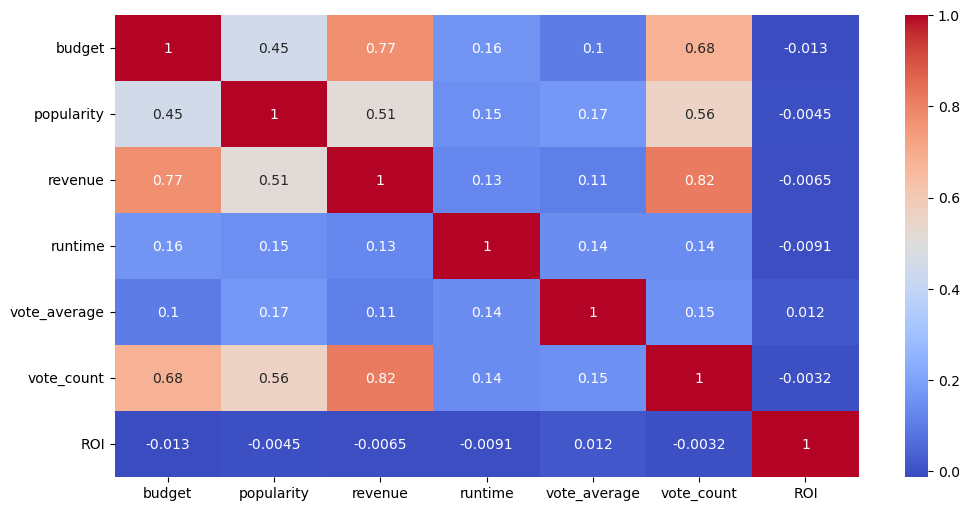

In [14]:
# Calculate the ROI
data['ROI'] = data['revenue'] / data['budget']

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

#### Analysis

We find that **budget** and **revenue** have a very high correlation at a factor of 0.77. This is not surprising since movie budgets also include marketing expenses and the cost of putting the movie in theatres.

Then, it is also not surprising to find that **revenue** is highly correlated with **vote count** at 0.82, since the more people who see a movie, the more people that will vote on its popularity.

It is interesting that the **budget** (0.45) and **revenue** (0.51) are only mildly correlated with **popularity**. This means that high budget movies can get people to the theatre, but there is also a decent chance of flopping.

**Machine learning**

In [22]:
# Select the features and target
features = ['budget', 'popularity', 'runtime']
target = 'revenue'

In [23]:
# Remove rows with missing values
data = data.dropna(subset=features + [target])

In [24]:
X = data[features]
y = data[target]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Create pipelines for both models
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='linear'))
])

gbr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

In [26]:
# Fit both models to the training data
svr_pipeline.fit(X_train, y_train)
gbr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=42))])

In [27]:
# Evaluate the models using testing data
svr_predictions = svr_pipeline.predict(X_test)
gbr_predictions = gbr_pipeline.predict(X_test)

svr_mse = mean_squared_error(y_test, svr_predictions)
gbr_mse = mean_squared_error(y_test, gbr_predictions)

svr_r2 = r2_score(y_test, svr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)

print("Support Vector Regression - Mean Squared Error:", svr_mse)
print("Gradient Boosting Regressor - Mean Squared Error:", gbr_mse)

print("Support Vector Regression - R2 Score:", svr_r2)
print("Gradient Boosting Regressor - R2 Score:", gbr_r2)

Support Vector Regression - Mean Squared Error: 6326588853810607.0
Gradient Boosting Regressor - Mean Squared Error: 1940415757368073.2
Support Vector Regression - R2 Score: -0.03932925394053299
Gradient Boosting Regressor - R2 Score: 0.6812293468027238


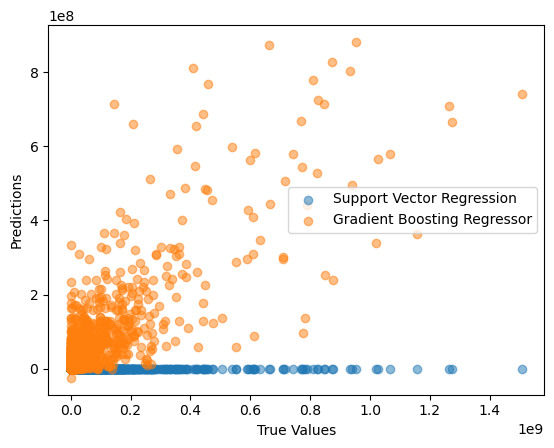

In [28]:
# Visualize the predictions
plt.scatter(y_test, svr_predictions, alpha=0.5, label="Support Vector Regression")
plt.scatter(y_test, gbr_predictions, alpha=0.5, label="Gradient Boosting Regressor")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.legend()
plt.savefig("predictions_comparison.png")
plt.show()

In [29]:
# Make predictions using a sample of new data
sample_data = X.sample(10, random_state=42)
svr_sample_predictions = svr_pipeline.predict(sample_data)
gbr_sample_predictions = gbr_pipeline.predict(sample_data)

In [30]:
# Compare the predictions
comparison = pd.DataFrame({"Support Vector Regression": svr_sample_predictions, "Gradient Boosting Regressor": gbr_sample_predictions})
print(comparison)

   Support Vector Regression  Gradient Boosting Regressor
0                -139.288621                 1.533986e+05
1                  48.580518                 1.533986e+05
2                -141.490627                 1.533986e+05
3                3006.679183                 1.345274e+07
4                 -23.871756                 1.533986e+05
5                -132.125246                 1.533986e+05
6                1158.583008                 1.533986e+05
7                 -82.721624                 1.533986e+05
8                 235.734721                 1.533986e+05
9                 -64.666235                 1.533986e+05


In [32]:
data

,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,81.0,Released,NaN,Toy Story,7.7,5415
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34
4,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31947,0,"[{'id': 878, 'name': 'Science Fiction'}]",222848,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,0.661558,"[{'name': 'Concorde-New Horizons', 'id': 4688}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-01-01,0,85.0,Released,NaN,Caged Heat 3000,3.5,1
31948,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,en,Robin Hood,"Yet another version of the classic epic, with ...",5.683753,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1991-05-13,0,104.0,Released,NaN,Robin Hood,5.7,26
31949,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0,90.0,Released,A deadly game of wits.,Betrayal,3.8,6
31950,0,[],227506,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0,87.0,Released,NaN,Satan Triumphant,0.0,0
